In [217]:
# packages that will be used and extra import that might be 

%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.io
import sys
import subprocess
from platform import python_version
from random import sample
from random import seed
import scipy.stats as stats
import matplotlib as mpl
import seaborn as sns
from math import ceil
import statsmodels.api as sm
#from statsmodels.stats import some_function_from_sms_module
from statsmodels.stats import proportion

In [218]:
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil


#Some plot styling preferences
%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.1, 
    alpha=0.05, 
    ratio=10
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print("required_n value is " + str(required_n))

required_n value is 141


<ipython-input-218-00859b41afba>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [219]:
# loading data
df_bridebook = pd.read_csv('/Users/ahmedadel/Downloads/Bridebook - Data Scientist , Task/Bridebook - DS - challengeData.1634399212.csv')
df_description = pd.read_excel('/Users/ahmedadel/Downloads/Bridebook - Data Scientist , Task/Bridebook - DS - challengeDataLegend.1634399212.xlsx')

In [220]:
#checking contingency table by crosstab function

df_bridebook.head()
df_bridebook.info
df_bridebook.columns
pd.crosstab(df_bridebook['testVariant'], df_bridebook['finOnb'])

finOnb,0,1
testVariant,,
0,51,536
1,27,270
2,11,156


In [221]:
# making sure there are no users that have been sampled multiple times.

session_counts = df_bridebook['userId'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

# 3894 users appear twice. To avoid repeating users, we'll delete them from the DataFrame as the number is low
if multi_users > 0 : 
    users_to_drop = session_counts[session_counts > 1].index

    df = df[~df['user_id'].isin(users_to_drop)]
    print(f' updated dataset now has {df.shape[0]} entries')

There are 0 users that appear multiple times in the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   userId               423 non-null    int64  
 1   regTime              423 non-null    int64  
 2   testVariant          423 non-null    int64  
 3   primaryAccount       423 non-null    bool   
 4   regPage              423 non-null    object 
 5   device               423 non-null    object 
 6   app                  423 non-null    bool   
 7   browser              423 non-null    object 
 8   browserVersion       163 non-null    float64
 9   screenHeight         423 non-null    int64  
 10  screenWidth          423 non-null    int64  
 11  authMethod           423 non-null    object 
 12  locationStep         423 non-null    object 
 13  addedCity            423 non-null    int64  
 14  locationCountry      178 non-null    object 
 15  addedGuestCount      423 non-null    boo

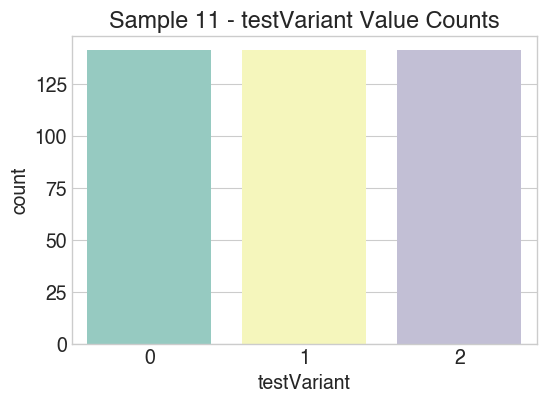

In [222]:
# Random Sampling 

control_sample0 = df_bridebook[df_bridebook['testVariant'] == 0].sample(n= required_n, random_state=20)
treatment_sample1 = df_bridebook[df_bridebook['testVariant'] == 1 ].sample(n=required_n, random_state=20)
treatment_sample2 = df_bridebook[df_bridebook['testVariant'] == 2 ].sample(n=required_n, random_state=20)

ab_test = pd.concat([control_sample0, treatment_sample1,treatment_sample2], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

ab_test.info()
ab_test['testVariant'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(x='testVariant', data=ab_test)
plt.title(f"Sample {i+1} - testVariant Value Counts")
plt.show()

# Store the result of each sample in the 'results' list
results.append(ab_test['testVariant'].value_counts())

<ipython-input-223-5923cf4b7dce>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')


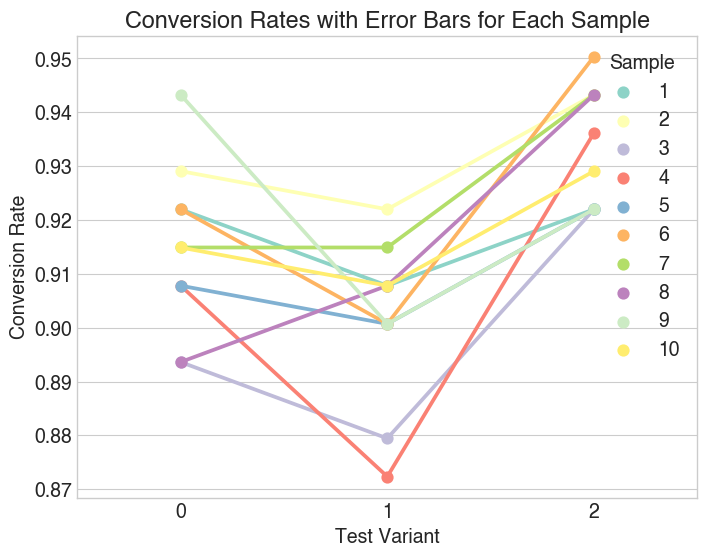

In [223]:
#visualization

conversion_rates = ab_test.groupby('testVariant')['finOnb']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with Error Bars for Each Sample')
plt.legend(title='Sample')
plt.show()

In [224]:
# multipe Random Sampling : premutation

#  calculation of the required_n and effect_size

results = []
seed =10
# looping to create and visualize the samples 10 times
for i in range(seed):
    control_sample = df_bridebook[df_bridebook['testVariant'] == 0].sample(n=required_n, random_state=i)
    treatment_sample1 = df_bridebook[df_bridebook['testVariant'] == 1].sample(n=required_n, random_state=i)
    treatment_sample2 = df_bridebook[df_bridebook['testVariant'] == 2].sample(n=required_n, random_state=i)

    ab_test = pd.concat([control_sample, treatment_sample1, treatment_sample2], axis=0)
    ab_test.reset_index(drop=True, inplace=True)

    #  conversion rates and related statistics
    conversion_rates = ab_test.groupby('testVariant')['finOnb']
    std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
    se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))
    conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
    conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

    # Append the conversion rates of each sample to the 'results' list
    results.append(conversion_rates)



# Now 'results' contains the conversion rates, std deviations, and std errors for each sample

for i, result in enumerate(results, start=1):
    print(f"\nSample {i} Conversion Rates:")
    print(result)


Sample 1 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.921986       0.268194   0.022586
1                   0.907801       0.289306   0.024364
2                   0.921986       0.268194   0.022586

Sample 2 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.929078       0.256694   0.021618
1                   0.921986       0.268194   0.022586
2                   0.943262       0.231341   0.019482

Sample 3 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.893617       0.308327   0.025966
1                   0.879433       0.325624   0.027422
2                   0.921986       0.268194   0.022586

Sample 4 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVari

 barplot for Plotting Conversion Rates with test variant for Each Sample 


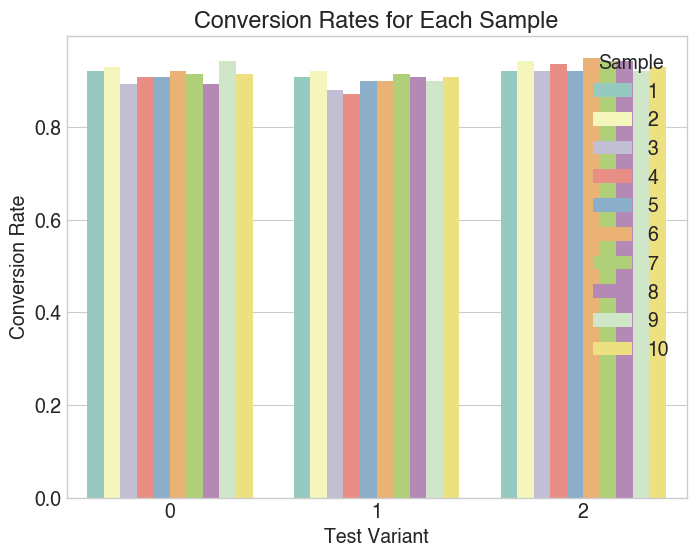

Bar plotting is showing a slightly positive indication towards a particular variant.
However, we will proceed plotting using a point plot for better visualization.



In [225]:
# plotting the result after permutation

result_df = pd.concat(results, keys=range(1, 11))  # Using 1 to 10 as sample labels

# Reset the index for the 'result_df' DataFrame
result_df.reset_index(inplace=True)

print(" barplot for Plotting Conversion Rates with test variant for Each Sample ")

plt.figure(figsize=(8, 6))
sns.barplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates for Each Sample')
plt.legend(title='Sample')
plt.show() 

# Message for the positive indication

print("Bar plotting is showing a slightly positive indication towards a particular variant.")
print("However, we will proceed plotting using a point plot for better visualization.\n")

 barplot for Plotting Conversion Rates with test variant for Each Sample 


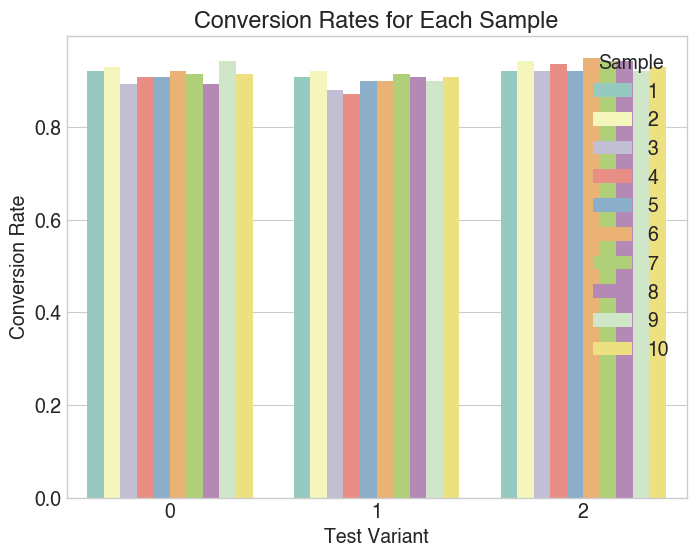

Bar plotting is showing a slightly positive indication towards a particular variant.
However, we will proceed plotting using a point plot for better visualization.



In [226]:
# plotting the result after permutation

result_df = pd.concat(results, keys=range(1, 11))  # Using 1 to 10 as sample labels

# Reset the index for the 'result_df' DataFrame
result_df.reset_index(inplace=True)

print(" barplot for Plotting Conversion Rates with test variant for Each Sample ")

plt.figure(figsize=(8, 6))
sns.barplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates for Each Sample')
plt.legend(title='Sample')
plt.show() 

# Message for the positive indication

print("Bar plotting is showing a slightly positive indication towards a particular variant.")
print("However, we will proceed plotting using a point plot for better visualization.\n")

 Plotting Conversion Rates with test variant for Each Sample 


<ipython-input-227-81ca75b2d2de>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')


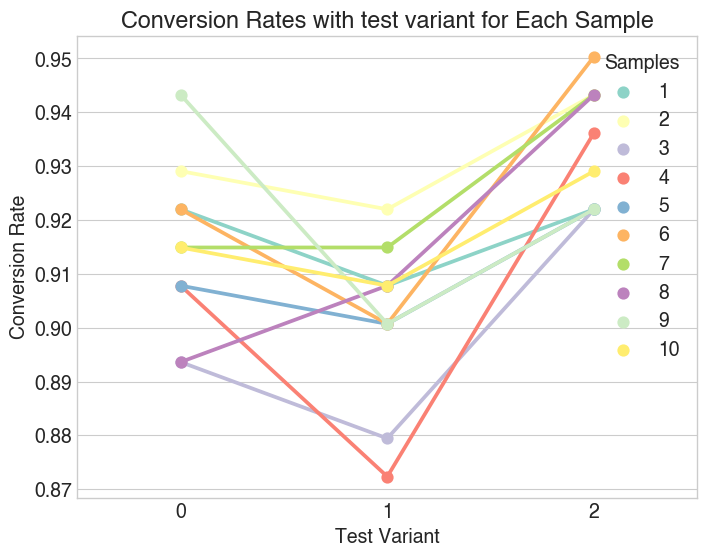

 Plotting std_deviations with test variant for Each Sample 


<ipython-input-227-81ca75b2d2de>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='std_deviation', hue='level_0', ci='sd')


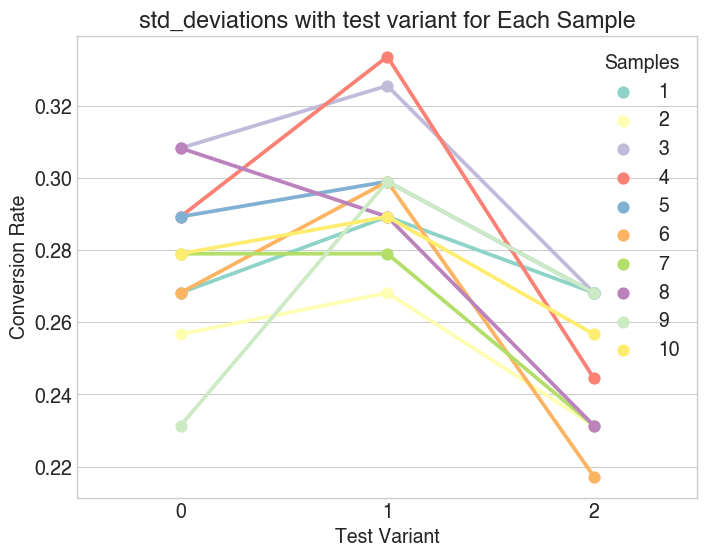

 Plotting std_error with test variant for Each Sample 


<ipython-input-227-81ca75b2d2de>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='std_error', hue='level_0', ci='sd')


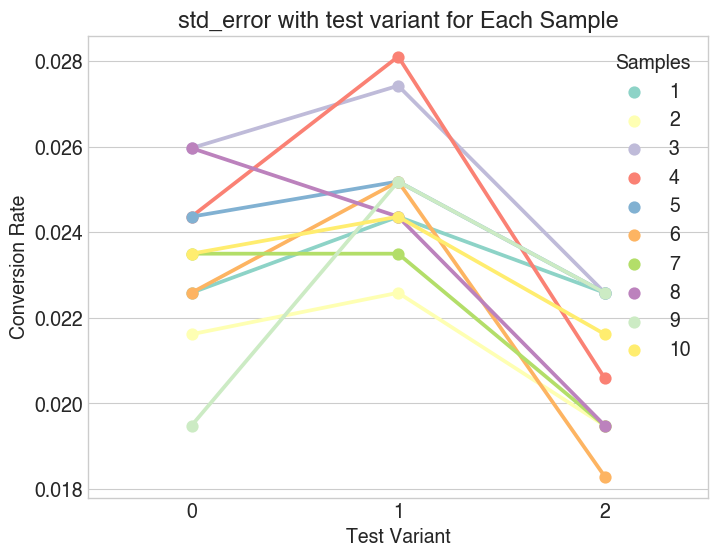

In [227]:
print(" Plotting Conversion Rates with test variant for Each Sample ")
plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with test variant for Each Sample')
plt.legend(title='Samples')
plt.show()

print(" Plotting std_deviations with test variant for Each Sample ")


plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='std_deviation', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('std_deviations with test variant for Each Sample')
plt.legend(title='Samples')
plt.show()

print(" Plotting std_error with test variant for Each Sample ")


plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='std_error', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('std_error with test variant for Each Sample')
plt.legend(title='Samples')
plt.show()

In [228]:
# Testing the hypothesis using z test will be repeated 2 times for 2 samples the 
# 1st variant 1 and control group

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['testVariant'] == 0]['finOnb']
treatment_results1 = ab_test[ab_test['testVariant'] == 1]['finOnb']


n_con = control_results.count()
n_treat1 = treatment_results1.count()


successes = [control_results.sum(), treatment_results1.sum()]
nobs = [n_con, n_treat1, ]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.20f}')
print(f'p-value: {pval:.30f}')
print(f'ci 95% for control group: [{lower_con:.6f}, {upper_con:.6f}]')
print(f'ci 95% for treatment group: [{lower_treat:.6f}, {upper_treat:.6f}]')

print("The p-value for 'variant1' is 0.834, much exceeding our significance limit of α=0.05. Thus, we must sustain the Null hypothesis Ho, suggesting that our new design did not show a statistically significant difference or improvement over the old one:(")
print("\n")
print("The treatment group's confidence interval ([86%, 96%]) shows the following:")
print("\n")
print("Our baseline conversion rate is 96%.")
print("The '95% we were not aiming for' deviates 1% downwards.")
print("\n")
print("These findings show that the new design's genuine conversion rate may be comparable to our baseline rather than increasing as we predicted. This suggests that our new design is unlikely to improve on the old design, forcing us to reconsider our strategy and start over!")

z statistic: 0.20950191069214080253
p-value: 0.834056443964556692982625918376
ci 95% for control group: [0.868836, 0.960952]
ci 95% for treatment group: [0.860049, 0.955554]
The p-value for 'variant1' is 0.834, much exceeding our significance limit of α=0.05. Thus, we must sustain the Null hypothesis Ho, suggesting that our new design did not show a statistically significant difference or improvement over the old one:(


The treatment group's confidence interval ([86%, 96%]) shows the following:


Our baseline conversion rate is 96%.
The '95% we were not aiming for' deviates 1% downwards.


These findings show that the new design's genuine conversion rate may be comparable to our baseline rather than increasing as we predicted. This suggests that our new design is unlikely to improve on the old design, forcing us to reconsider our strategy and start over!


In [229]:
# Testing the hypothesis using z test will be repeated 2 times for 2 samples the 
# 2nd variant 1 and control group

control_results = ab_test[ab_test['testVariant'] == 0]['finOnb']
treatment_results2 = ab_test[ab_test['testVariant'] == 2]['finOnb']


n_con = control_results.count()
n_treat2 = treatment_results2.count()


successes = [control_results.sum(), treatment_results2.sum()]
nobs = [n_con, n_treat2 ]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.20f}')
print(f'p-value: {pval:.30f}')
print(f'ci 95% for control group: [{lower_con:.6f}, {upper_con:.6f}]')
print(f'ci 95% for treatment group: [{lower_treat:.6f}, {upper_treat:.6f}]')

z statistic: -0.44407521570427432867
p-value: 0.656988204588702773278896529519
ci 95% for control group: [0.868836, 0.960952]
ci 95% for treatment group: [0.886708, 0.971448]


In [230]:
#Testing the hypothesis By performing Anova for multiple samples and variants
# combined all the samples into a single DataFrame for ANOVA test


results = []
seed = 10

# Use a for loop to create and visualize the samples 10 times
for i in range(seed):
    control_sample = df_bridebook[df_bridebook['testVariant'] == 0].sample(n=required_n, random_state=i)
    treatment_sample1 = df_bridebook[df_bridebook['testVariant'] == 1].sample(n=required_n, random_state=i)
    treatment_sample2 = df_bridebook[df_bridebook['testVariant'] == 2].sample(n=required_n, random_state=i)

    ab_test = pd.concat([control_sample, treatment_sample1, treatment_sample2], axis=0)
    ab_test.reset_index(drop=True, inplace=True)

    # Calculate conversion rates and related statistics
    conversion_rates = ab_test.groupby('testVariant')['finOnb']
    std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
    se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))
    conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
    conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

    # Append the conversion rates of each sample to the 'results' list
    results.append(conversion_rates)

# Now 'results' contains the conversion rates, std deviations, and std errors for each sample

# Check the contents of the 'results' list to identify any issues
for i, result in enumerate(results, start=1):
    print(f"\nSample {i} Conversion Rates:")
    print(result)

anova_df = pd.concat([results[i - 1] for i in range(1, seed + 1)], keys=range(1, seed + 1))

# Perform the ANOVA test
# Here, we are assuming that 'finOnb' is the column containing the data you want to compare among the groups
anova_result = stats.f_oneway(*[group['conversion_rate'] for name, group in anova_df.groupby('testVariant')])

# Print the ANOVA test results
print(f'ANOVA F-statistic: {anova_result.statistic:.2f}')
print(f'p-value: {anova_result.pvalue:.20f}')


Sample 1 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.921986       0.268194   0.022586
1                   0.907801       0.289306   0.024364
2                   0.921986       0.268194   0.022586

Sample 2 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.929078       0.256694   0.021618
1                   0.921986       0.268194   0.022586
2                   0.943262       0.231341   0.019482

Sample 3 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.893617       0.308327   0.025966
1                   0.879433       0.325624   0.027422
2                   0.921986       0.268194   0.022586

Sample 4 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVari

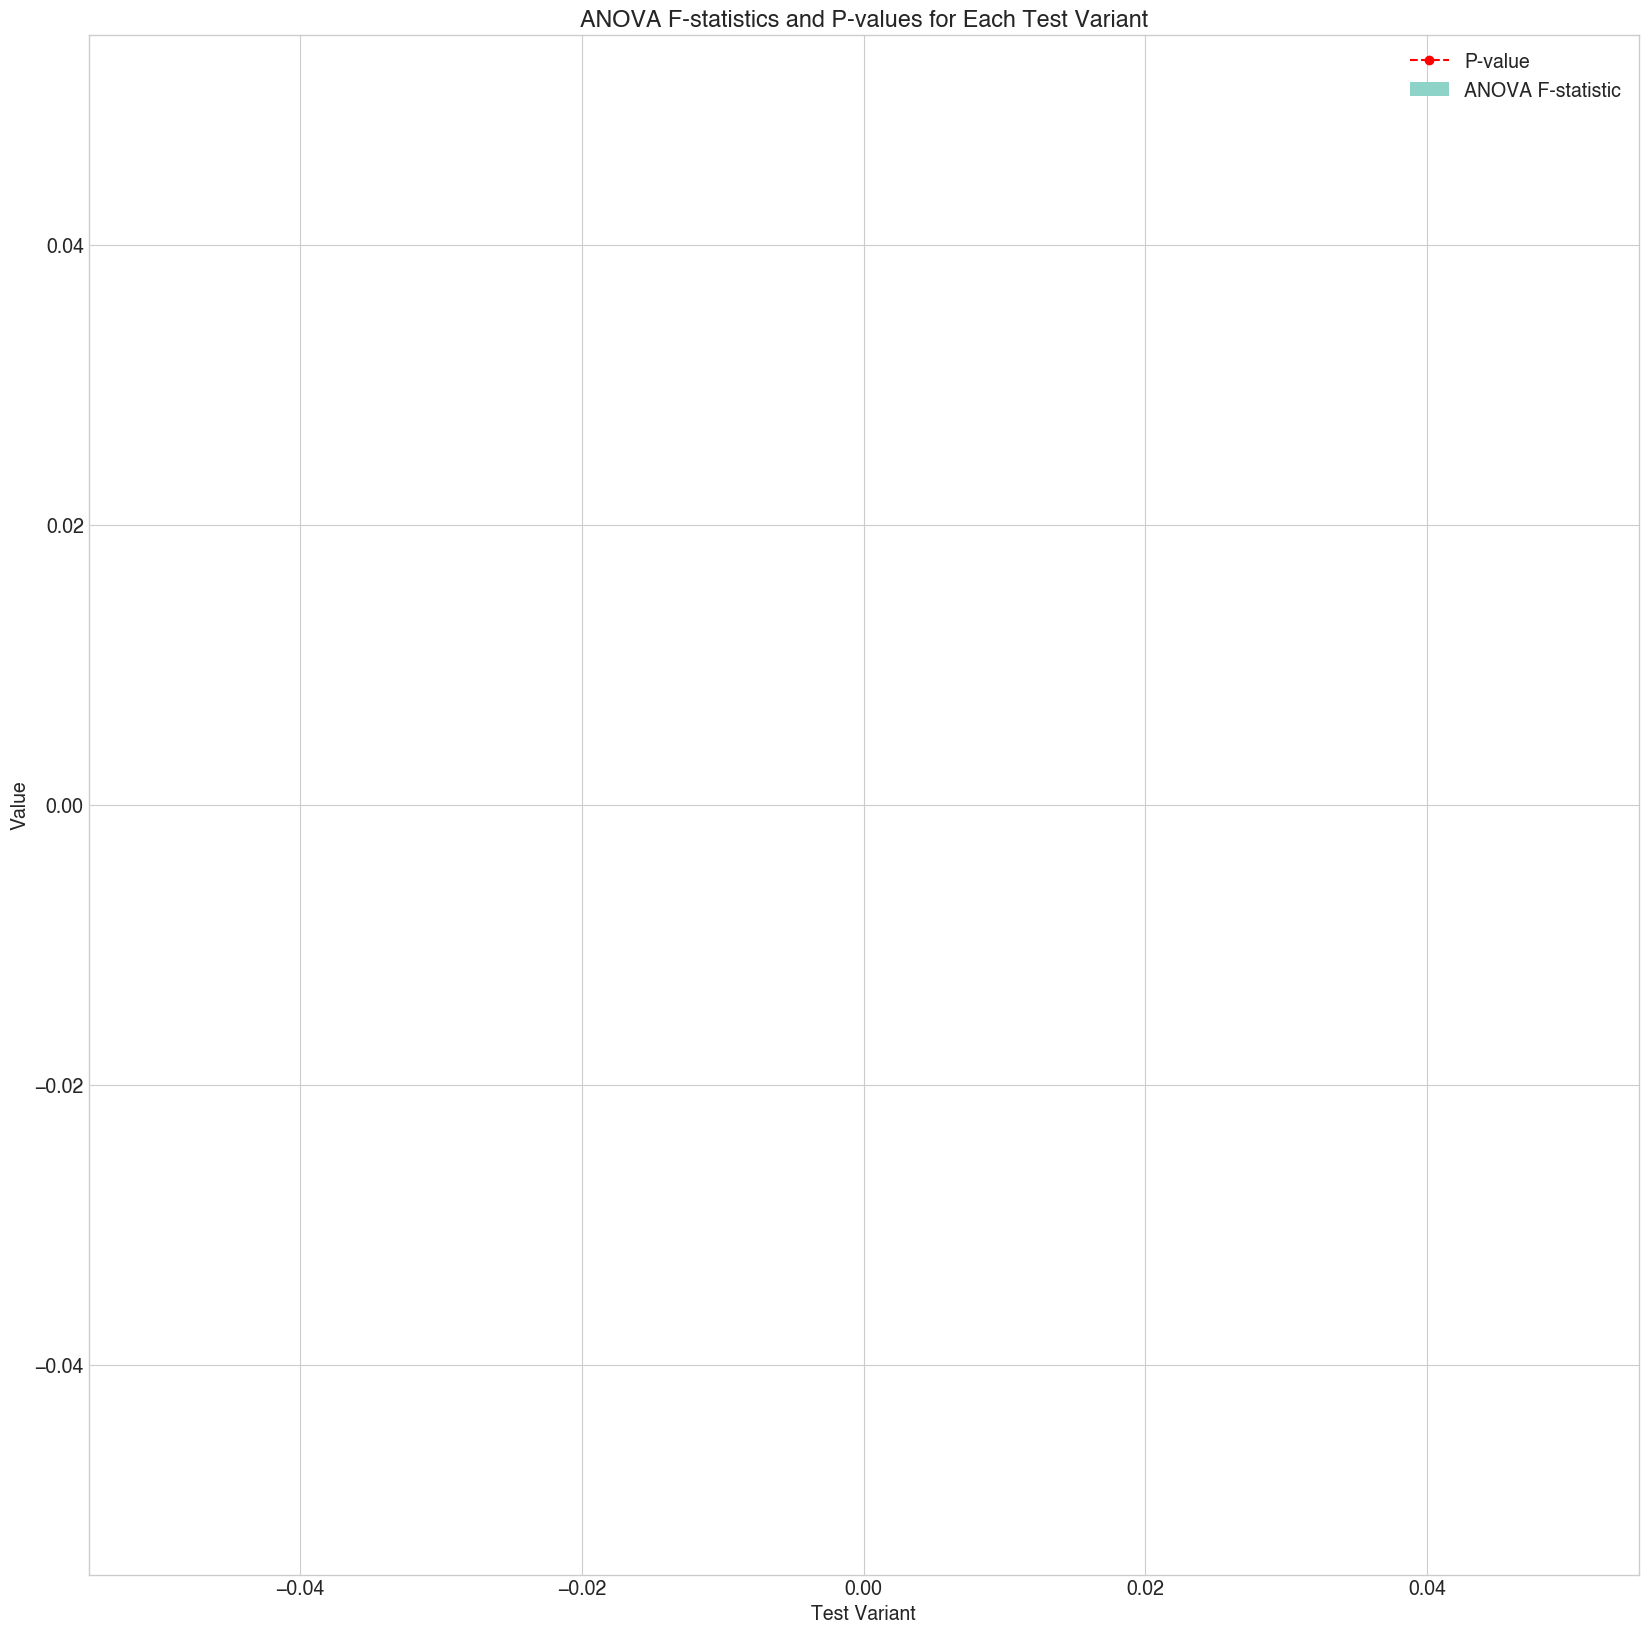

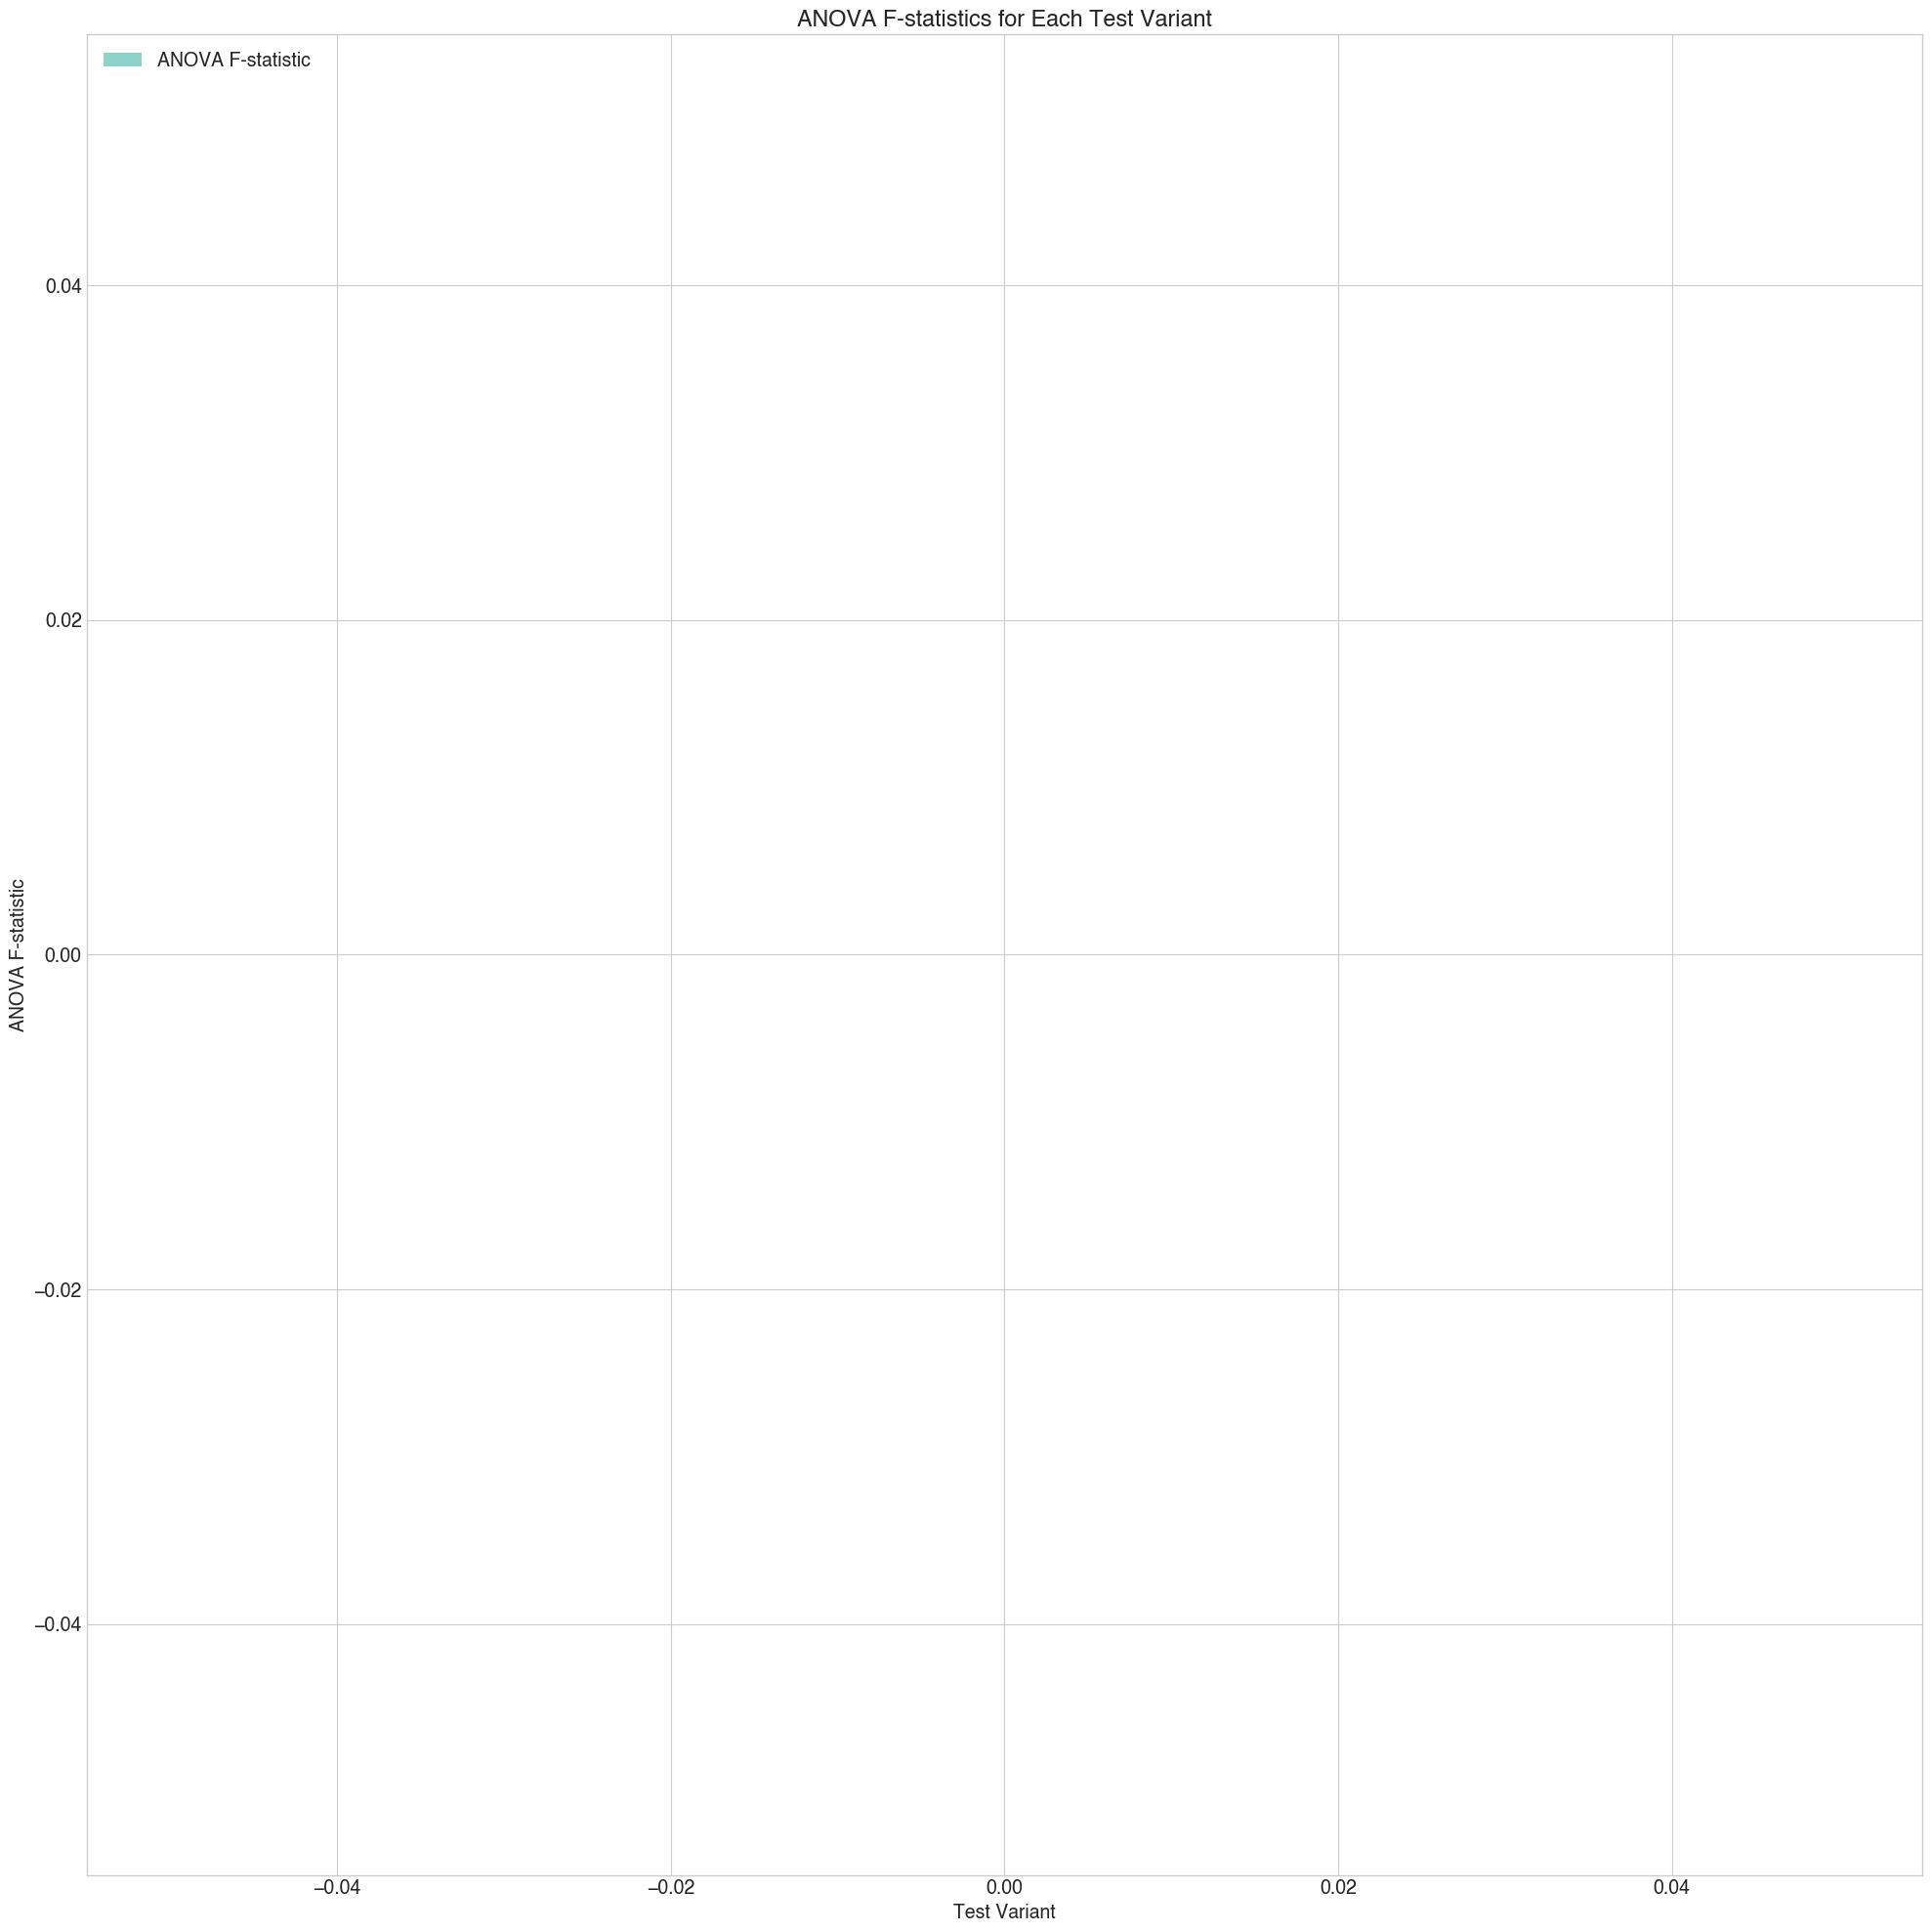

In [231]:
#This plotting cell is for plotting the p and anova values but values are ver small it's not showing up properly
#anyway its not necessary as currently we have values of the hypothesis test already

plt.figure(figsize=(20, 20))

# Plot ANOVA F-statistics for each test variant
f_statistics = [result.statistic for result in anova_results.values()]
variant_labels = [f'Variant {variant}' for variant in anova_results.values()]
plt.bar(variant_labels, f_statistics, label='ANOVA F-statistic')

# Plot p-values for each test variant as a line
p_values = [result.pvalue for result in anova_results.values()]
plt.plot(variant_labels, p_values, color='red', label='P-value', marker='o', linestyle='dashed')

# Add text labels with p-values in scientific notation
p_values_sci = [f"{val:.00009e}" for val in p_values]
for i, val in enumerate(p_values):
    plt.text(i, val, p_values_sci[i], ha='center', va='bottom', color='red')

plt.xlabel('Test Variant')
plt.ylabel('Value')
plt.title('ANOVA F-statistics and P-values for Each Test Variant')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(20, 20))

# Plot ANOVA F-statistics for each test variant
f_statistics = [result.statistic for result in anova_results.values()]
variant_labels = [f'Variant {variant}' for variant in anova_results.keys()]
plt.bar(variant_labels, f_statistics, label='ANOVA F-statistic')

# Add text labels to the bars
for i, val in enumerate(f_statistics):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom')

plt.xlabel('Test Variant')
plt.ylabel('ANOVA F-statistic')
plt.title('ANOVA F-statistics for Each Test Variant')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [232]:
#checking contingency table by crosstab function

df_bridebook.head()
df_bridebook.info
df_bridebook.columns
pd.crosstab(df_bridebook['testVariant'], df_bridebook['finOnb'])

finOnb,0,1
testVariant,,
0,51,536
1,27,270
2,11,156


In [233]:
# making sure there are no users that have been sampled multiple times.

session_counts = df_bridebook['userId'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

# 3894 users appear twice. To avoid repeating users, we'll delete them from the DataFrame as the number is low
if multi_users > 0 : 
    users_to_drop = session_counts[session_counts > 1].index

    df = df[~df['user_id'].isin(users_to_drop)]
    print(f' updated dataset now has {df.shape[0]} entries')

There are 0 users that appear multiple times in the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   userId               423 non-null    int64  
 1   regTime              423 non-null    int64  
 2   testVariant          423 non-null    int64  
 3   primaryAccount       423 non-null    bool   
 4   regPage              423 non-null    object 
 5   device               423 non-null    object 
 6   app                  423 non-null    bool   
 7   browser              423 non-null    object 
 8   browserVersion       163 non-null    float64
 9   screenHeight         423 non-null    int64  
 10  screenWidth          423 non-null    int64  
 11  authMethod           423 non-null    object 
 12  locationStep         423 non-null    object 
 13  addedCity            423 non-null    int64  
 14  locationCountry      178 non-null    object 
 15  addedGuestCount      423 non-null    boo

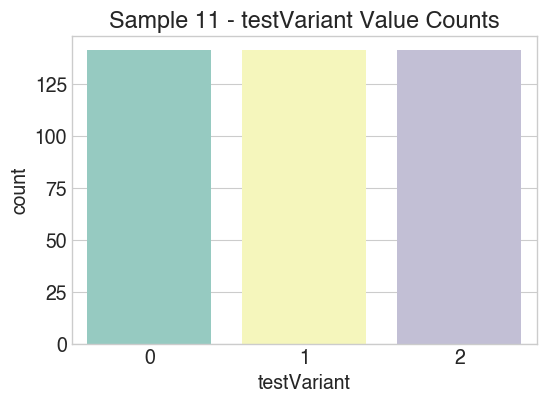

In [234]:
# Random Sampling 

control_sample0 = df_bridebook[df_bridebook['testVariant'] == 0].sample(n= required_n, random_state=20)
treatment_sample1 = df_bridebook[df_bridebook['testVariant'] == 1 ].sample(n=required_n, random_state=20)
treatment_sample2 = df_bridebook[df_bridebook['testVariant'] == 2 ].sample(n=required_n, random_state=20)

ab_test = pd.concat([control_sample0, treatment_sample1,treatment_sample2], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

ab_test.info()
ab_test['testVariant'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(x='testVariant', data=ab_test)
plt.title(f"Sample {i+1} - testVariant Value Counts")
plt.show()

# Store the result of each sample in the 'results' list
results.append(ab_test['testVariant'].value_counts())

<ipython-input-235-493f8832e80f>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')


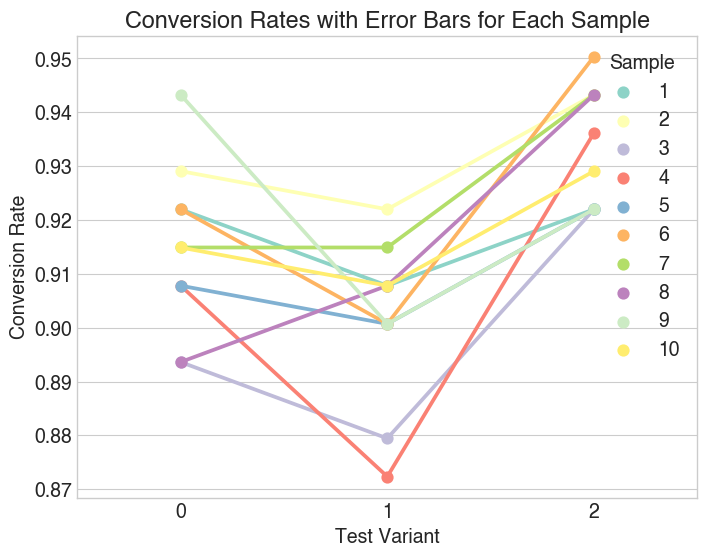

In [235]:
#Checking conversion rates and visualize it

conversion_rates = ab_test.groupby('testVariant')['finOnb']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with Error Bars for Each Sample')
plt.legend(title='Sample')
plt.show()

<ipython-input-236-6ec32a577d50>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')


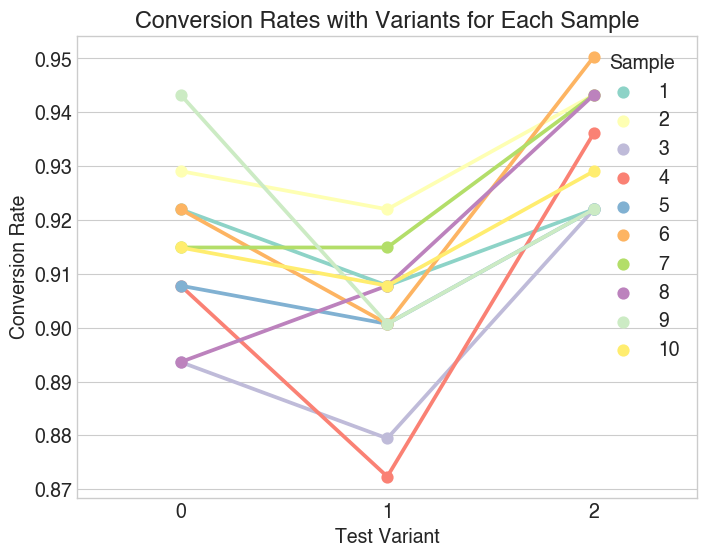

In [236]:
#Checking conversion rates and visualize it

conversion_rates = ab_test.groupby('testVariant')['finOnb']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with Variants for Each Sample')
plt.legend(title='Sample')
plt.show()

<ipython-input-237-6ec32a577d50>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')


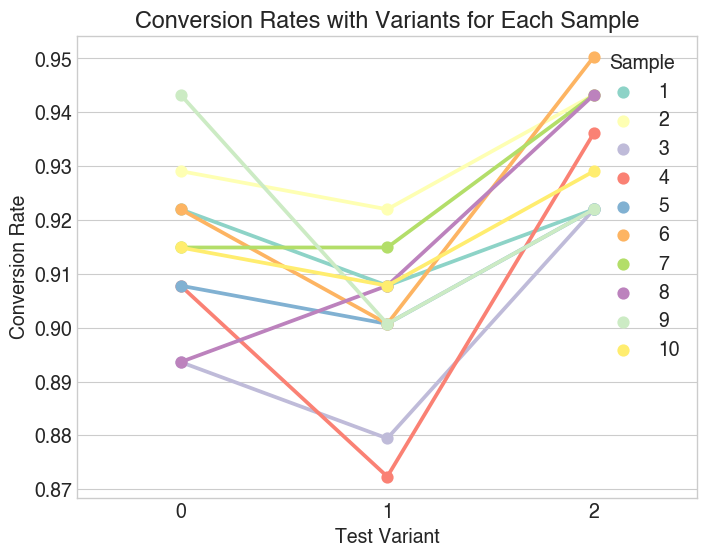

In [237]:
#Checking conversion rates and visualize it

conversion_rates = ab_test.groupby('testVariant')['finOnb']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with Variants for Each Sample')
plt.legend(title='Sample')
plt.show()

In [238]:
# multipe Random Sampling : 

#  calculation of the required_n and effect_size

results = []
seed =10
# looping to create and visualize the samples 10 times
for i in range(seed):
    control_sample = df_bridebook[df_bridebook['testVariant'] == 0].sample(n=required_n, random_state=i)
    treatment_sample1 = df_bridebook[df_bridebook['testVariant'] == 1].sample(n=required_n, random_state=i)
    treatment_sample2 = df_bridebook[df_bridebook['testVariant'] == 2].sample(n=required_n, random_state=i)

    ab_test = pd.concat([control_sample, treatment_sample1, treatment_sample2], axis=0)
    ab_test.reset_index(drop=True, inplace=True)

    #  conversion rates and related statistics
    conversion_rates = ab_test.groupby('testVariant')['finOnb']
    std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
    se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))
    conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
    conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

    # Append the conversion rates of each sample to the 'results' list
    results.append(conversion_rates)



# Now 'results' contains the conversion rates, std deviations, and std errors for each sample

for i, result in enumerate(results, start=1):
    print(f"\nSample {i} Conversion Rates:")
    print(result)


Sample 1 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.921986       0.268194   0.022586
1                   0.907801       0.289306   0.024364
2                   0.921986       0.268194   0.022586

Sample 2 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.929078       0.256694   0.021618
1                   0.921986       0.268194   0.022586
2                   0.943262       0.231341   0.019482

Sample 3 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.893617       0.308327   0.025966
1                   0.879433       0.325624   0.027422
2                   0.921986       0.268194   0.022586

Sample 4 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVari

 barplot for Plotting Conversion Rates with test variant for Each Sample 


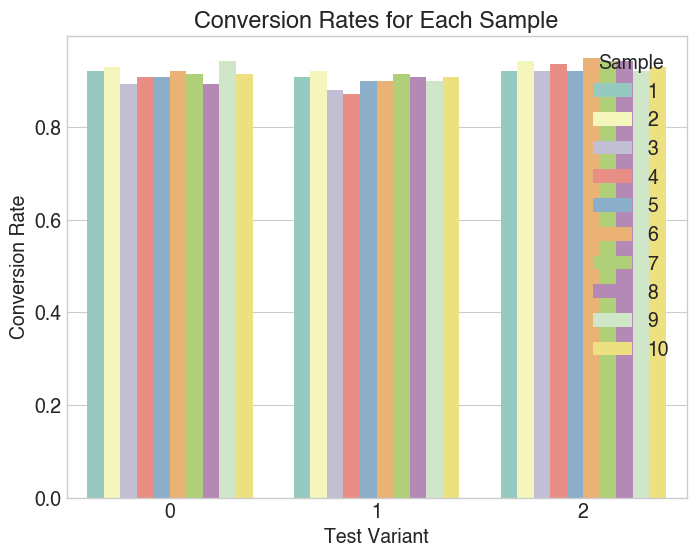

Bar plotting is showing a slightly positive indication towards a particular variant.
However, we will proceed plotting using a point plot for better visualization.



In [239]:
# plotting the result after permutation

result_df = pd.concat(results, keys=range(1, 11))  # Using 1 to 10 as sample labels

# Reset the index for the 'result_df' DataFrame
result_df.reset_index(inplace=True)

print(" barplot for Plotting Conversion Rates with test variant for Each Sample ")

plt.figure(figsize=(8, 6))
sns.barplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates for Each Sample')
plt.legend(title='Sample')
plt.show() 

# Message for the positive indication

print("Bar plotting is showing a slightly positive indication towards a particular variant.")
print("However, we will proceed plotting using a point plot for better visualization.\n")

 Plotting Conversion Rates with test variant for Each Sample 


<ipython-input-240-81ca75b2d2de>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')


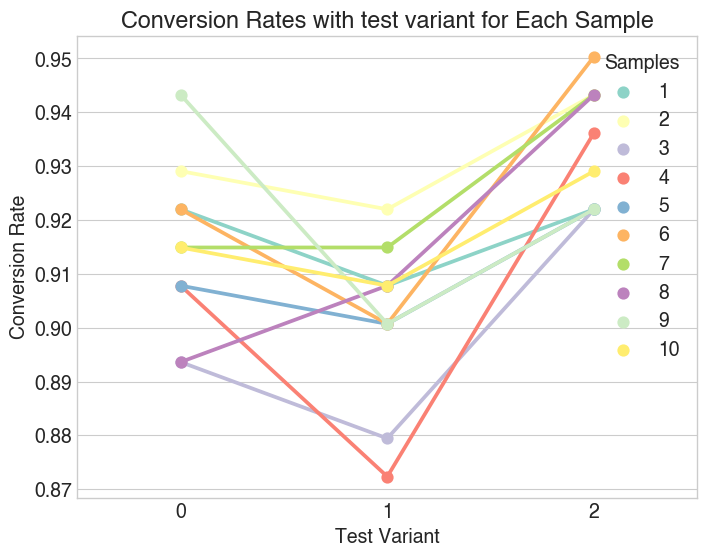

 Plotting std_deviations with test variant for Each Sample 


<ipython-input-240-81ca75b2d2de>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='std_deviation', hue='level_0', ci='sd')


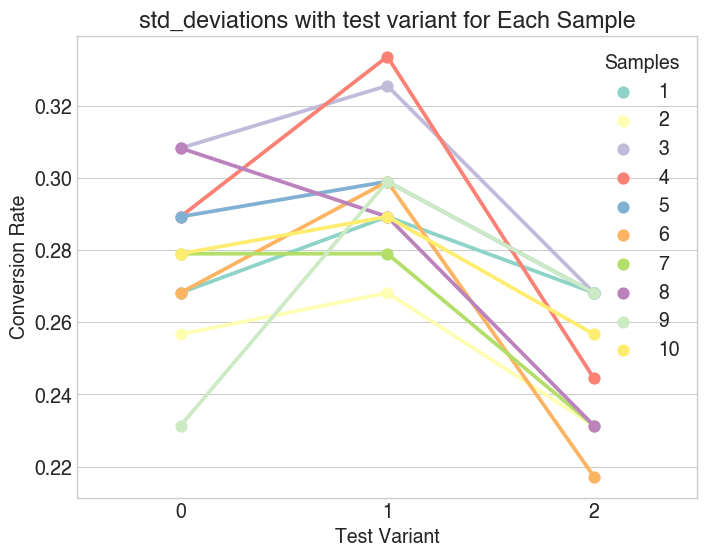

 Plotting std_error with test variant for Each Sample 


<ipython-input-240-81ca75b2d2de>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=result_df, x='testVariant', y='std_error', hue='level_0', ci='sd')


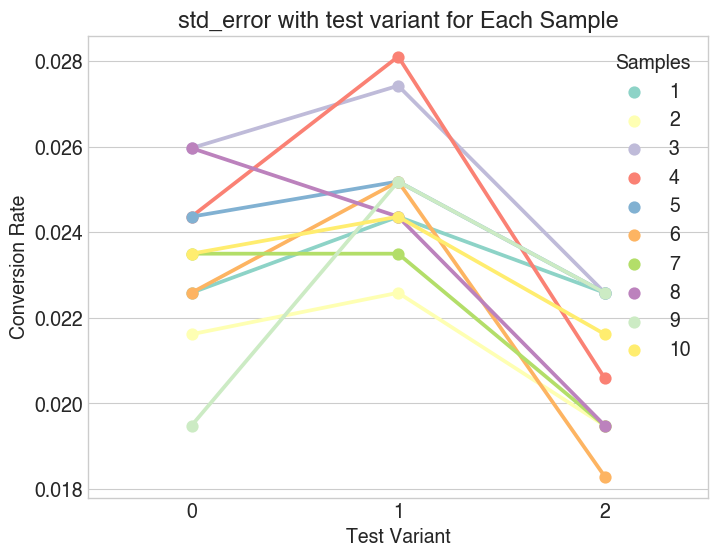

In [240]:
print(" Plotting Conversion Rates with test variant for Each Sample ")
plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='conversion_rate', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with test variant for Each Sample')
plt.legend(title='Samples')
plt.show()

print(" Plotting std_deviations with test variant for Each Sample ")


plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='std_deviation', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('std_deviations with test variant for Each Sample')
plt.legend(title='Samples')
plt.show()

print(" Plotting std_error with test variant for Each Sample ")


plt.figure(figsize=(8, 6))
sns.pointplot(data=result_df, x='testVariant', y='std_error', hue='level_0', ci='sd')
plt.xlabel('Test Variant')
plt.ylabel('Conversion Rate')
plt.title('std_error with test variant for Each Sample')
plt.legend(title='Samples')
plt.show()

In [241]:
# Testing the hypothesis using z test will be repeated 2 times for 2 samples the 
# 1st variant 1 and control group

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['testVariant'] == 0]['finOnb']
treatment_results1 = ab_test[ab_test['testVariant'] == 1]['finOnb']


n_con = control_results.count()
n_treat1 = treatment_results1.count()


successes = [control_results.sum(), treatment_results1.sum()]
nobs = [n_con, n_treat1, ]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.20f}')
print(f'p-value: {pval:.30f}')
print(f'ci 95% for control group: [{lower_con:.6f}, {upper_con:.6f}]')
print(f'ci 95% for treatment group: [{lower_treat:.6f}, {upper_treat:.6f}]')

print("The p-value for 'variant1' is 0.834, much exceeding our significance limit of α=0.05. Thus, we must sustain the Null hypothesis Ho, suggesting that our new design did not show a statistically significant difference or improvement over the old one:(")
print("\n")
print("The treatment group's confidence interval ([86%, 96%]) shows the following:")
print("\n")
print("Our baseline conversion rate is 96%.")
print("The '95% we were not aiming for' deviates 1% downwards.")
print("\n")
print("These findings show that the new design's genuine conversion rate may be comparable to our baseline rather than increasing as we predicted. This suggests that our new design is unlikely to improve on the old design, forcing us to reconsider our strategy and start over!")

z statistic: 0.20950191069214080253
p-value: 0.834056443964556692982625918376
ci 95% for control group: [0.868836, 0.960952]
ci 95% for treatment group: [0.860049, 0.955554]
The p-value for 'variant1' is 0.834, much exceeding our significance limit of α=0.05. Thus, we must sustain the Null hypothesis Ho, suggesting that our new design did not show a statistically significant difference or improvement over the old one:(


The treatment group's confidence interval ([86%, 96%]) shows the following:


Our baseline conversion rate is 96%.
The '95% we were not aiming for' deviates 1% downwards.


These findings show that the new design's genuine conversion rate may be comparable to our baseline rather than increasing as we predicted. This suggests that our new design is unlikely to improve on the old design, forcing us to reconsider our strategy and start over!


In [242]:
# Testing the hypothesis using z test will be repeated 2 times for 2 samples the 
# 2nd variant 1 and control group

control_results = ab_test[ab_test['testVariant'] == 0]['finOnb']
treatment_results2 = ab_test[ab_test['testVariant'] == 2]['finOnb']


n_con = control_results.count()
n_treat2 = treatment_results2.count()


successes = [control_results.sum(), treatment_results2.sum()]
nobs = [n_con, n_treat2 ]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.20f}')
print(f'p-value: {pval:.30f}')
print(f'ci 95% for control group: [{lower_con:.6f}, {upper_con:.6f}]')
print(f'ci 95% for treatment group: [{lower_treat:.6f}, {upper_treat:.6f}]')

z statistic: -0.44407521570427432867
p-value: 0.656988204588702773278896529519
ci 95% for control group: [0.868836, 0.960952]
ci 95% for treatment group: [0.886708, 0.971448]


In [243]:
#Testing the hypothesis By performing Anova for multiple samples and variants
# combined all the samples into a single DataFrame for ANOVA test


results = []
seed = 10

# Use a for loop to create and visualize the samples 10 times
for i in range(seed):
    control_sample = df_bridebook[df_bridebook['testVariant'] == 0].sample(n=required_n, random_state=i)
    treatment_sample1 = df_bridebook[df_bridebook['testVariant'] == 1].sample(n=required_n, random_state=i)
    treatment_sample2 = df_bridebook[df_bridebook['testVariant'] == 2].sample(n=required_n, random_state=i)

    ab_test = pd.concat([control_sample, treatment_sample1, treatment_sample2], axis=0)
    ab_test.reset_index(drop=True, inplace=True)

    # Calculate conversion rates and related statistics
    conversion_rates = ab_test.groupby('testVariant')['finOnb']
    std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
    se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))
    conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
    conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

    # Append the conversion rates of each sample to the 'results' list
    results.append(conversion_rates)

# Now 'results' contains the conversion rates, std deviations, and std errors for each sample

# Check the contents of the 'results' list to identify any issues
for i, result in enumerate(results, start=1):
    print(f"\nSample {i} Conversion Rates:")
    print(result)

anova_df = pd.concat([results[i - 1] for i in range(1, seed + 1)], keys=range(1, seed + 1))

# Perform the ANOVA test
# Here, we are assuming that 'finOnb' is the column containing the data you want to compare among the groups
anova_result = stats.f_oneway(*[group['conversion_rate'] for name, group in anova_df.groupby('testVariant')])

# Print the ANOVA test results
print(f'ANOVA F-statistic: {anova_result.statistic:.2f}')
print(f'p-value: {anova_result.pvalue:.20f}')


Sample 1 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.921986       0.268194   0.022586
1                   0.907801       0.289306   0.024364
2                   0.921986       0.268194   0.022586

Sample 2 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.929078       0.256694   0.021618
1                   0.921986       0.268194   0.022586
2                   0.943262       0.231341   0.019482

Sample 3 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVariant                                           
0                   0.893617       0.308327   0.025966
1                   0.879433       0.325624   0.027422
2                   0.921986       0.268194   0.022586

Sample 4 Conversion Rates:
             conversion_rate  std_deviation  std_error
testVari

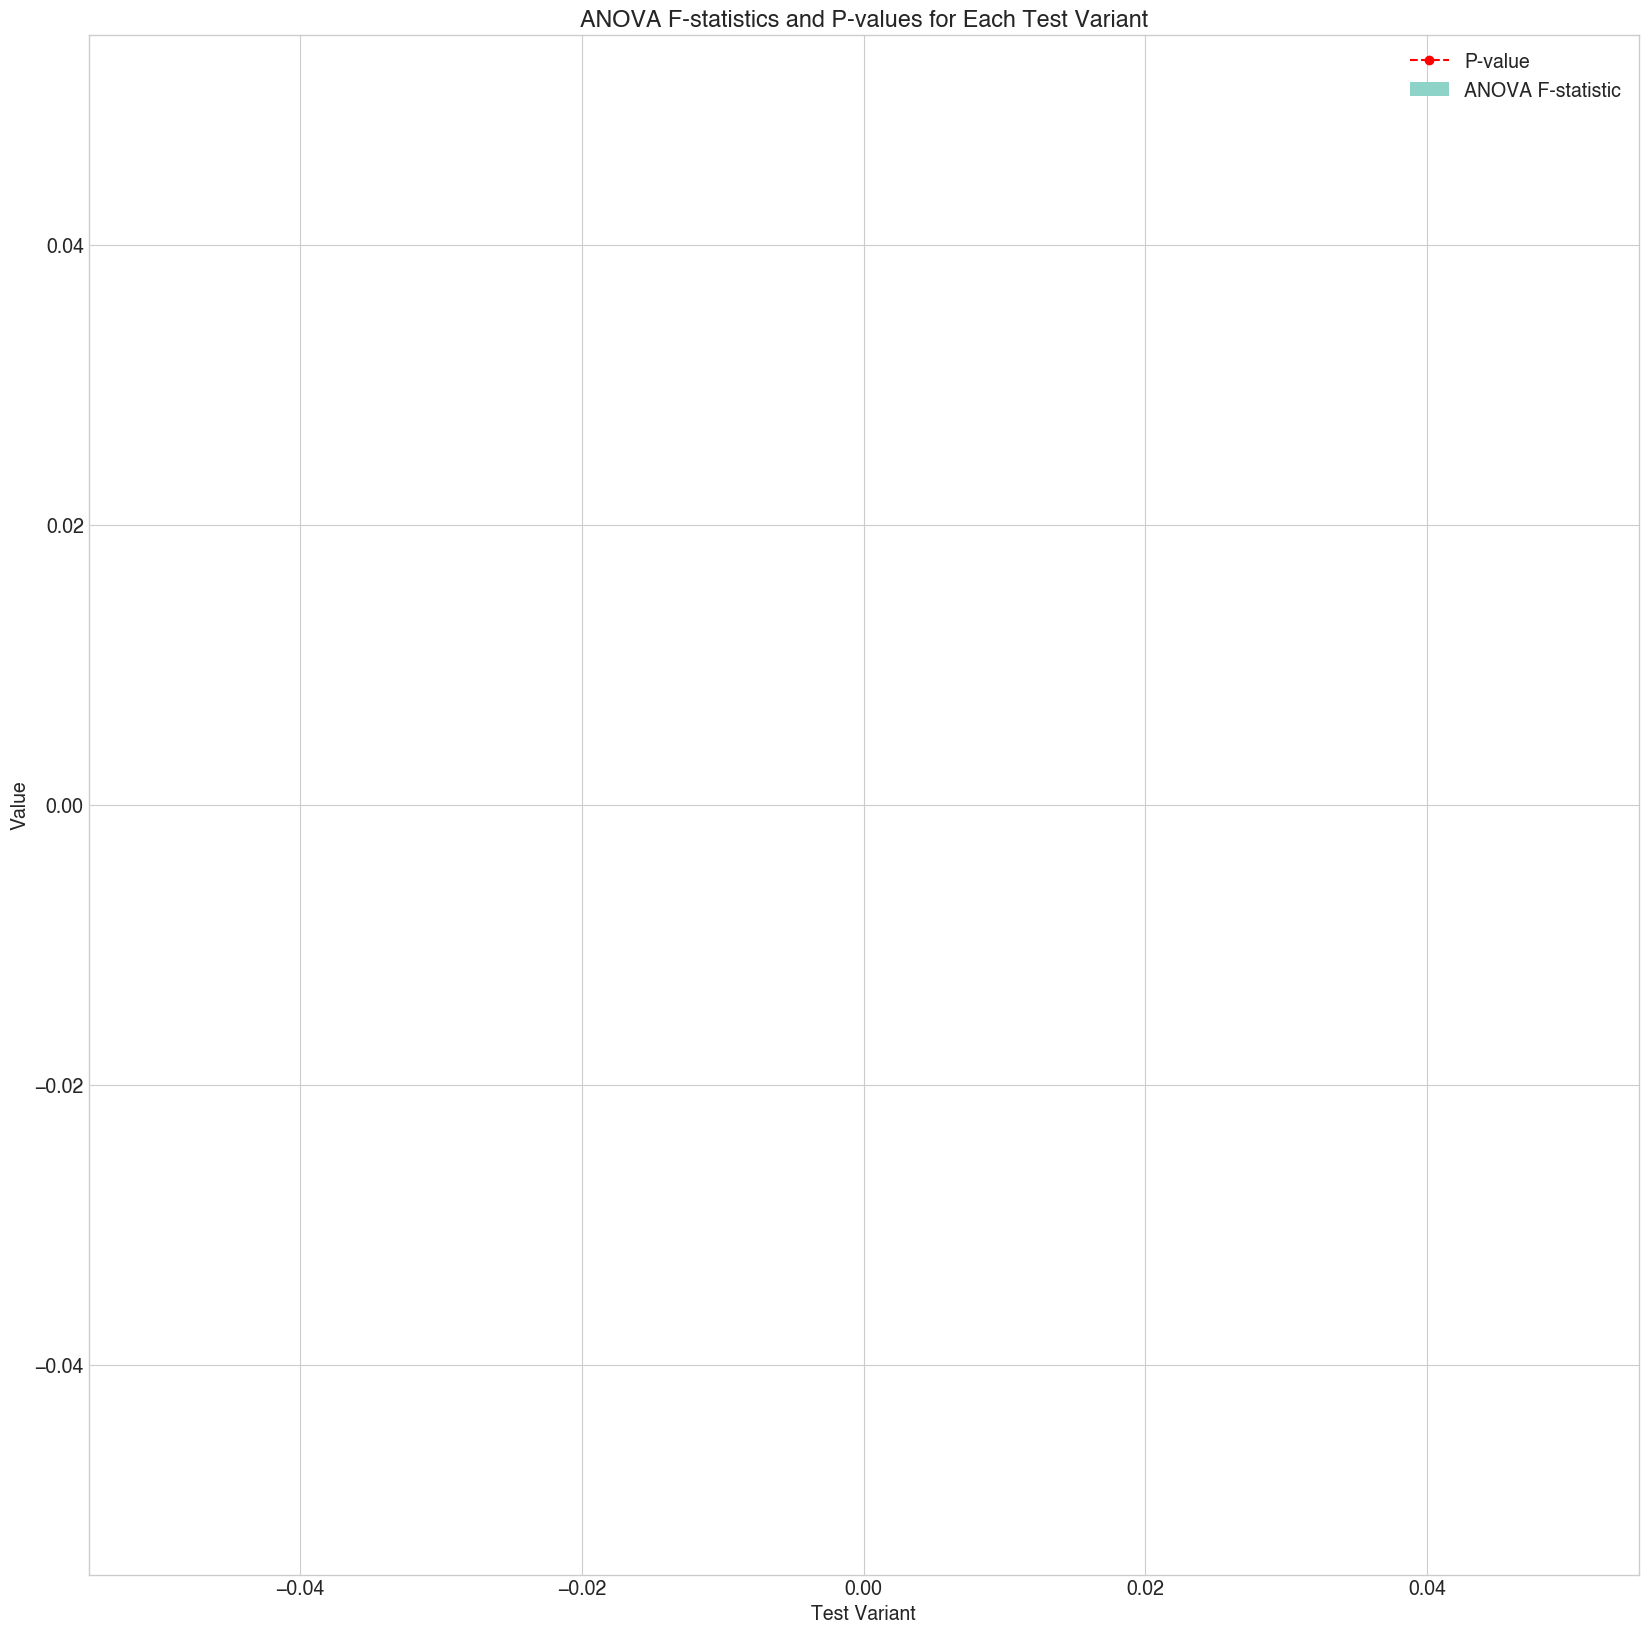

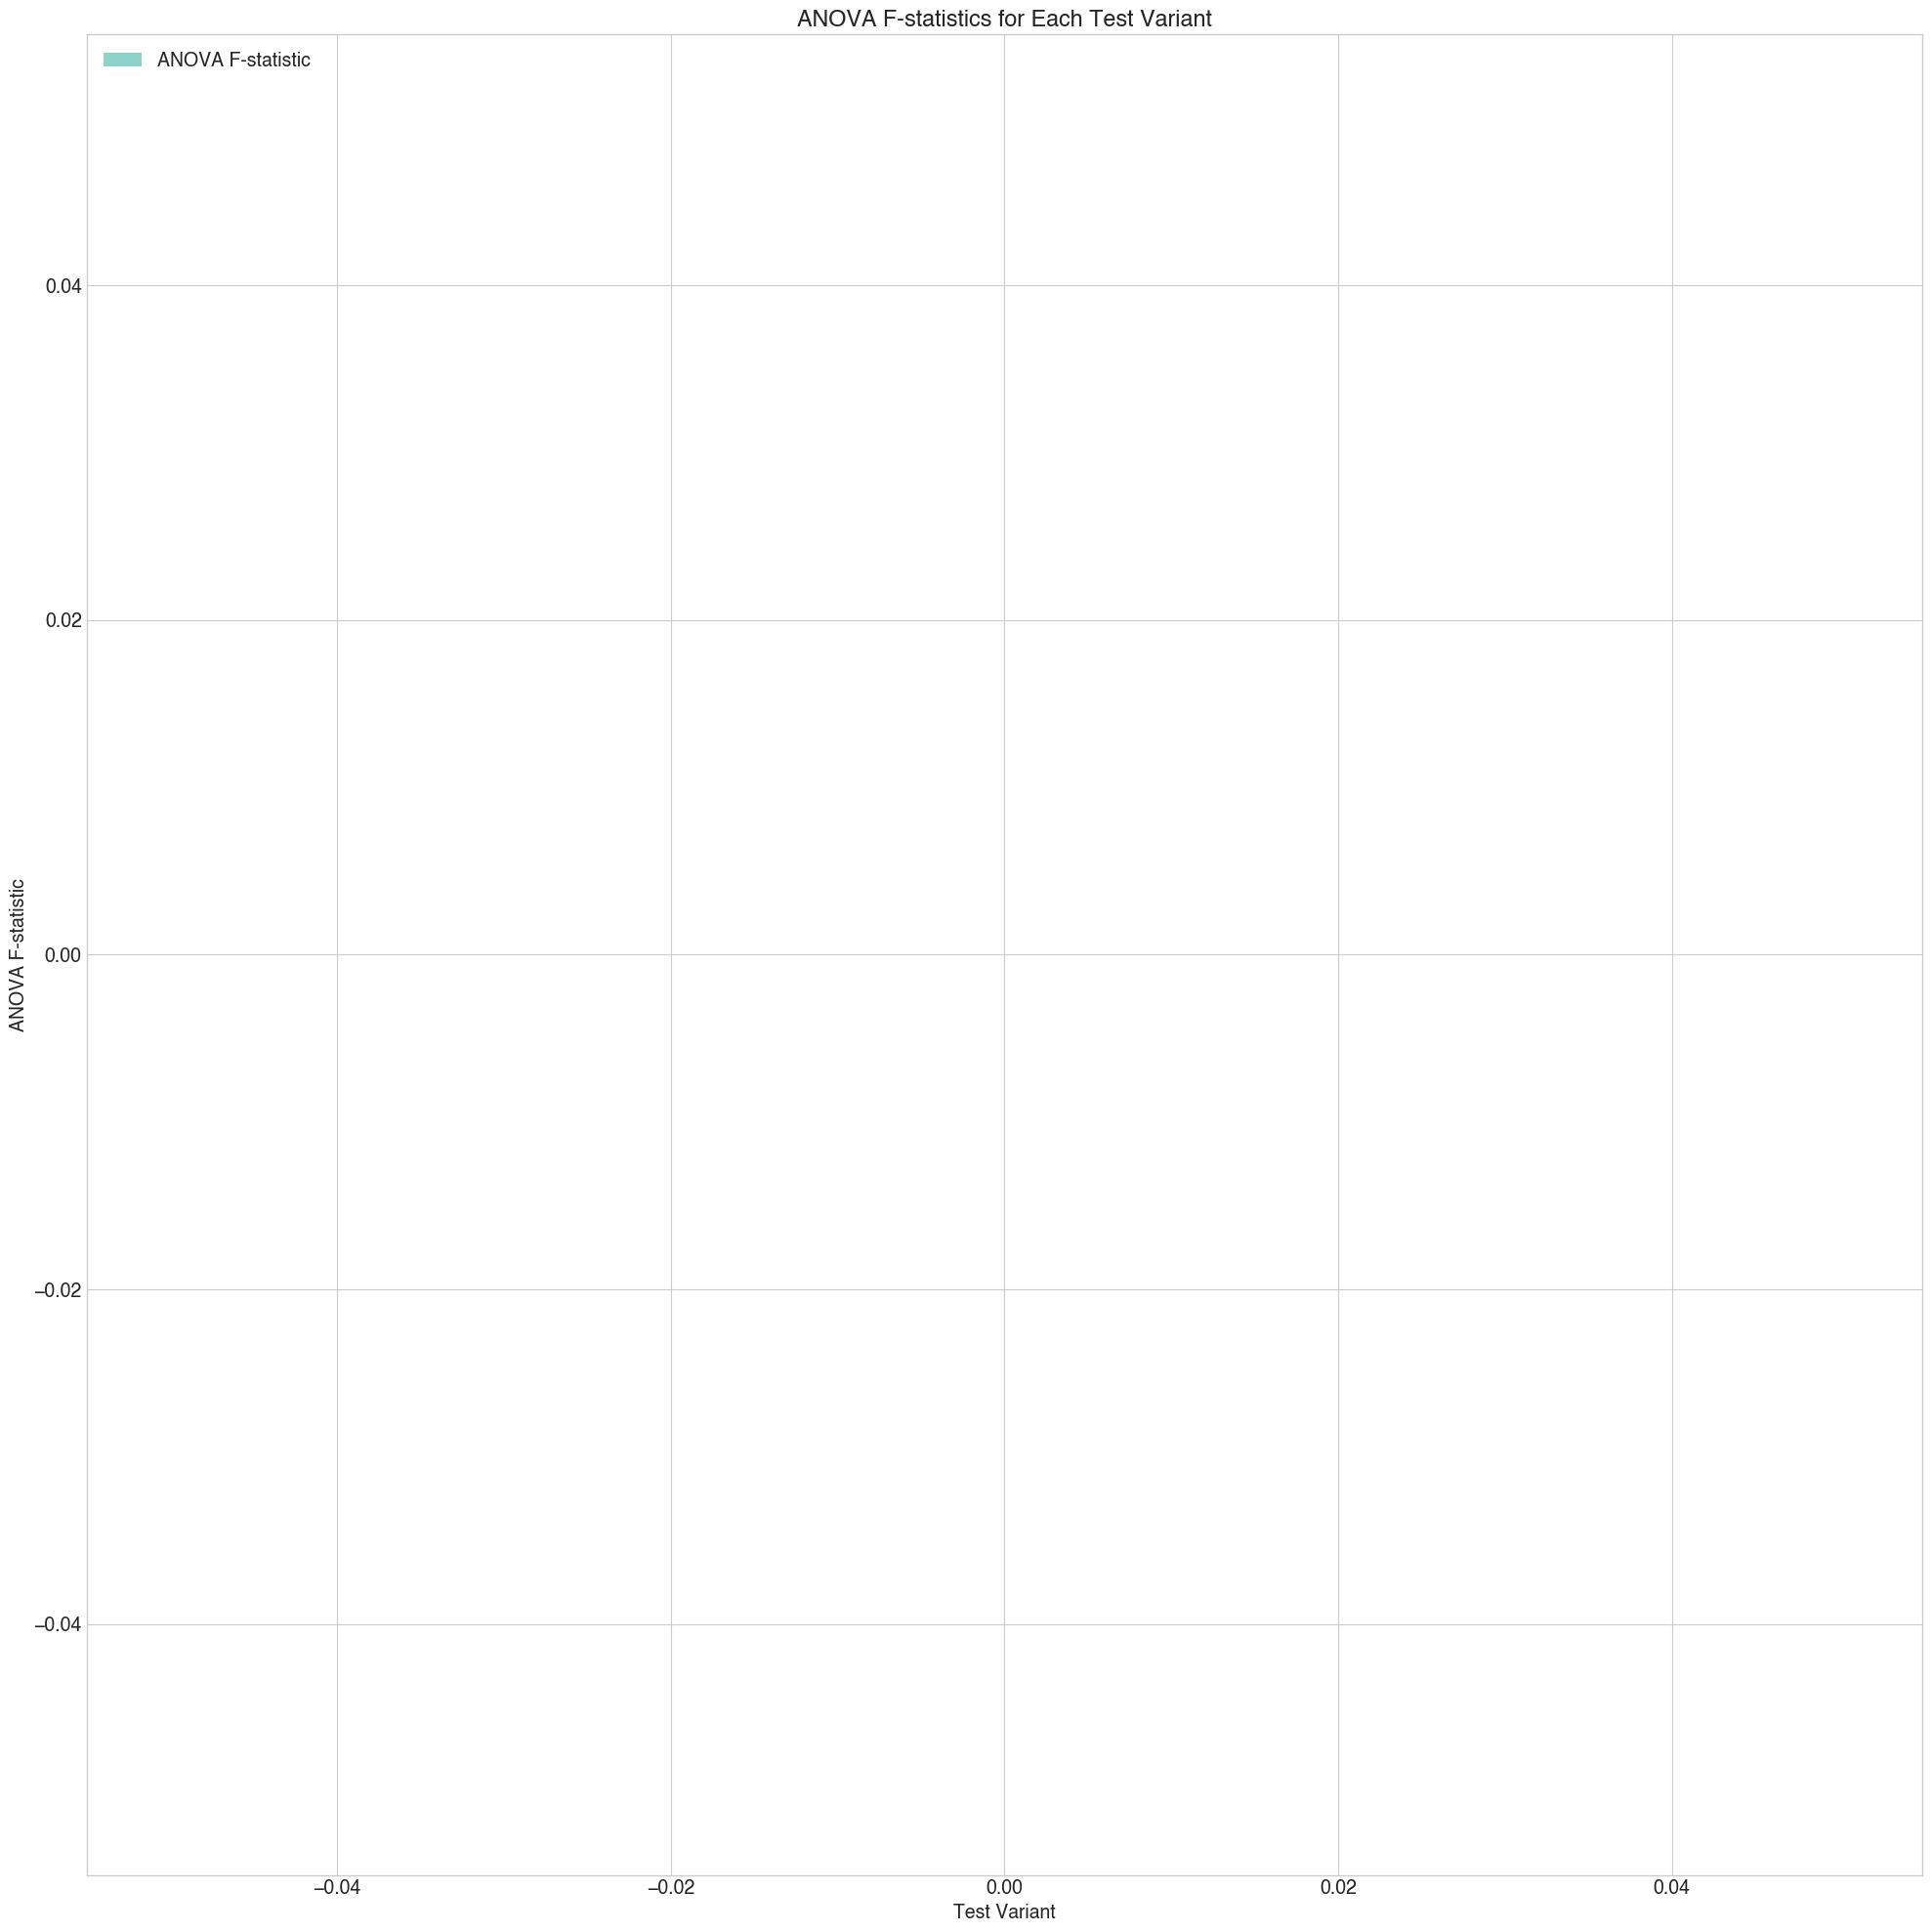

In [244]:
#This plotting cell is for plotting the p and anova values but values are ver small it's not showing up properly
#anyway its not necessary as currently we have values of the hypothesis test already

plt.figure(figsize=(20, 20))

# Plot ANOVA F-statistics for each test variant
f_statistics = [result.statistic for result in anova_results.values()]
variant_labels = [f'Variant {variant}' for variant in anova_results.values()]
plt.bar(variant_labels, f_statistics, label='ANOVA F-statistic')

# Plot p-values for each test variant as a line
p_values = [result.pvalue for result in anova_results.values()]
plt.plot(variant_labels, p_values, color='red', label='P-value', marker='o', linestyle='dashed')

# Add text labels with p-values in scientific notation
p_values_sci = [f"{val:.00009e}" for val in p_values]
for i, val in enumerate(p_values):
    plt.text(i, val, p_values_sci[i], ha='center', va='bottom', color='red')

plt.xlabel('Test Variant')
plt.ylabel('Value')
plt.title('ANOVA F-statistics and P-values for Each Test Variant')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(20, 20))

# Plot ANOVA F-statistics for each test variant
f_statistics = [result.statistic for result in anova_results.values()]
variant_labels = [f'Variant {variant}' for variant in anova_results.keys()]
plt.bar(variant_labels, f_statistics, label='ANOVA F-statistic')

# Add text labels to the bars
for i, val in enumerate(f_statistics):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom')

plt.xlabel('Test Variant')
plt.ylabel('ANOVA F-statistic')
plt.title('ANOVA F-statistics for Each Test Variant')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()